# 1.Setup

In [56]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import config

# 2.数据加载、探索

## 2.1 数据加载

In [57]:
df_small_noise = pd.read_csv(config.train_data_dir, parse_dates = True, index_col = "timestamp")
df_daily_jumpsup = pd.read_csv(config.test_data_dir, parse_dates = True, index_col = "timestamp")
print("Training data:\n", df_small_noise.head())
print("Training data shape:", df_small_noise.shape)

print("Testing data:\n", df_daily_jumpsup.head())
print("Testing data shape:", df_daily_jumpsup.shape)

Training data:
                          value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
Training data shape: (4032, 1)
Testing data:
                          value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739
Testing data shape: (4032, 1)


## 2.2 数据探索

### 2.2.1 Timeseries data without anomalies, for training

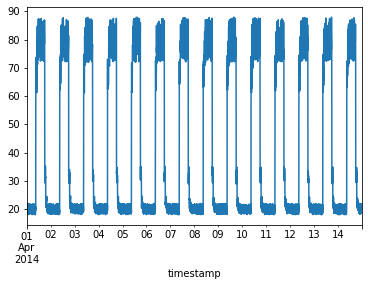

In [58]:
fig, ax = plt.subplots()
df_small_noise.plot(legend = False, ax = ax)
plt.show()

### 2.2.2 Timeseries data with anomalies, for testing

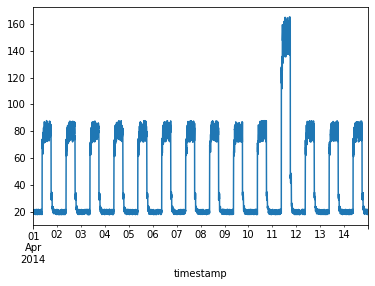

In [59]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend = False, ax = ax)
plt.show()

## 2.3 训练数据准备

### 2.3.1 数据标准化

In [60]:
def normalize_test(values, mean, std):
    """
    数据标准化
    """
    values -= mean
    values /= std
    return values

In [61]:
# Traing mean and std
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()

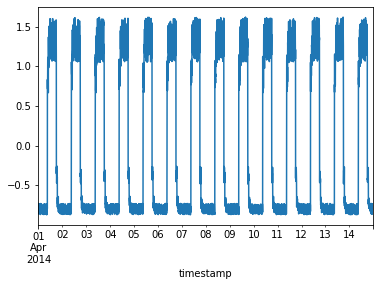

In [62]:
# Train data
df_training_value = normalize_test(df_small_noise, training_mean, training_std)

fig, ax = plt.subplots()
df_training_value.plot(legend = False, ax = ax)
plt.show()

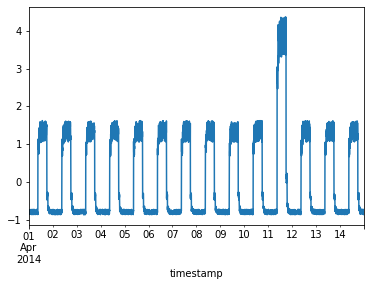

In [63]:
# Test data
df_test_value = normalize_test(df_daily_jumpsup, training_mean, training_std)

fig, ax = plt.subplots()
df_test_value.plot(legend = False, ax = ax)
plt.show()

### 2.3.2 数据序列化

In [64]:
TIME_STEPS = 288
def create_sequences(values, time_steps = TIME_STEPS):
    """
    Generated training sequences for use in the model.
    """
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i:(i + time_steps)])
    return np.stack(output)

In [65]:
x_train = create_sequences(df_training_value.values)
print(f"Training input shape:{x_train.shape}")

Training input shape:(3744, 288, 1)


In [66]:
# Test data
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3744, 288, 1)


# 3.模型构建

* convolutional reconstruction autoencoder model

## 3.1 模型构建

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_5 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr (None, 288, 1)           

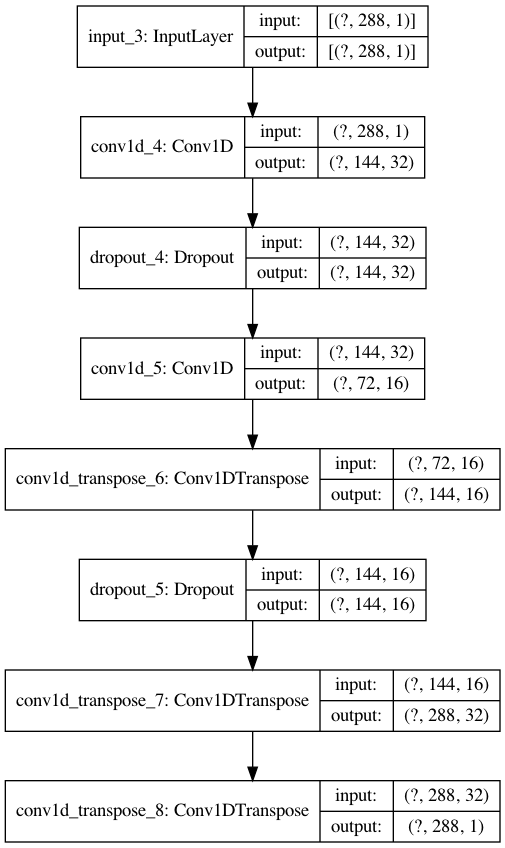

In [67]:
model = keras.Sequential([
    layers.Input(shape = (x_train.shape[1], x_train.shape[2])),
    layers.Conv1D(filters = 32, kernel_size = 7, padding = "same", strides = 2, activation = "relu"),
    layers.Dropout(rate = 0.2),
    layers.Conv1D(filters = 16, kernel_size = 7, padding = "same", strides = 2, activation = "relu"),
    layers.Conv1DTranspose(filters = 16, kernel_size = 7, padding = "same", strides = 2, activation = "relu"),
    layers.Dropout(rate = 0.2),
    layers.Conv1DTranspose(filters = 32, kernel_size = 7, padding = "same", strides = 2, activation = "relu"),
    layers.Conv1DTranspose(filters = 1, kernel_size = 7, padding = "same"),
])
model.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate = 0.001))
model.summary()
keras.utils.plot_model(model, show_shapes = True)

## 3.2 模型训练

In [68]:
history = model.fit(
    x_train,
    x_train,
    epochs = 50,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 42ms/step - loss: 0.4651 - val_loss: 0.0782
Epoch 2/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0743 - val_loss: 0.0376
Epoch 3/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0540 - val_loss: 0.0321
Epoch 4/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0455 - val_loss: 0.0271
Epoch 5/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0397 - val_loss: 0.0245
Epoch 6/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0351 - val_loss: 0.0242
Epoch 7/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0318 - val_loss: 0.0225
Epoch 8/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0293 - val_loss: 0.0222
Epoch 9/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0271 - val_loss: 0.0197
Epoch 10/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0253 - val_loss: 0.0195
Epoch 11/

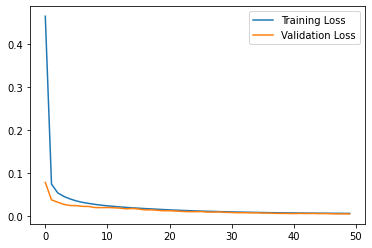

In [69]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

# 4.异常值检测

1. 在训练样本上找到MAE损失. 
2. 查找最大MAE损失值. 这是我们的模型在尝试重建样本时执行的最糟糕的情况. 我们将其threshold用于异常检测. 
3. 如果样本的重建损失大于该threshold 值, 那么我们可以推断出该模型正在看到它不熟悉的模式. 我们将此样品标记为anomaly. 

## 4.1 寻找训练数据上的最大 MAE

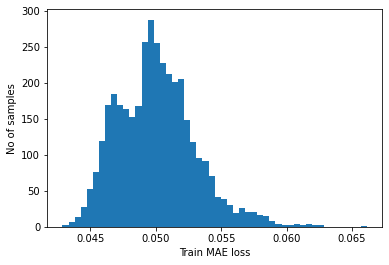

Reconstruction error threshold:  0.06612101914386798


In [70]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)
plt.hist(train_mae_loss, bins = 50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

## 4.2 测试数据异常值检测

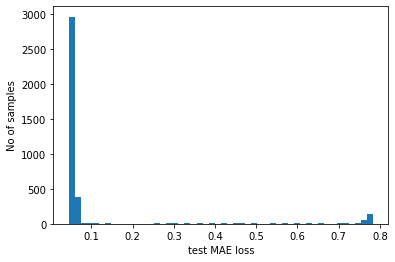

Number of anomaly samples:  402
Indices of anomaly samples:  (array([ 793,  794,  974, 2521, 2523, 2701, 2702, 2703, 2704, 2705, 2706,
       2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717,
       2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728,
       2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739,
       2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750,
       2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761,
       2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772,
       2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783,
       2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794,
       2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805,
       2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816,
       2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827,
       2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2

In [71]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [72]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

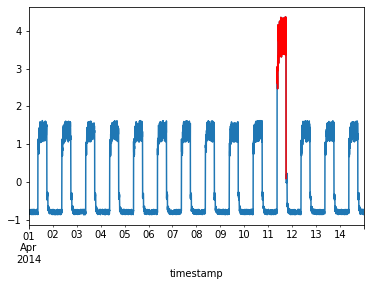

In [73]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()